# Creating Ontology of 311 Park Names -> official park names

This notebook creates a match dictionary between park names in 311 data and in NYC Parks official dataset. 
Using this dictionary we can match each park-related call to specific park or park District

Here I am using [fuzzywuzzy module](https://github.com/seatgeek/fuzzywuzzy)

In [6]:
__author__ = "Philipp Kats"
__date__ = "2015_10_15"

import pandas as pd
import geopandas as gp
import os
from fuzzywuzzy import process  ## fuzzy string match in python

%pylab inline
PARQA = os.getenv('PARQA') #basic path

Populating the interactive namespace from numpy and matplotlib


## Getting Data: both 311 Calls names and Park official names to match

In [7]:
def clean(x):
    return x.lower().replace('pool - ','').replace('playground','').strip()

In [8]:
calls = pd.DataFrame(pd.read_csv(PARQA + '/data/311DPR.csv',encoding='utf8'))


/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
callParks = calls[calls.Agency=='DPR'][['Park Facility Name',
                                                     'Borough']].drop_duplicates()

callParks['cleanName'] = callParks['Park Facility Name'].apply(clean)
print '311_call_names total:', len(callParks['Park Facility Name'])


callP = calls[(calls.Agency=='DPR') & (calls['Location Type']=='Park')]

311_call_names total: 1672


In [10]:
# rename Borough to BoroughCode

borrowCode = pd.DataFrame({'Borough':['BROOKLYN',
                                      'QUEENS',
                                      'MANHATTAN',
                                      'BRONX',
                                      'STATEN ISLAND',
                                      'Unspecified'],
                           'code':['B',
                                   'Q',
                                   'M',
                                   'X',
                                   'R',
                                   '?']})

callParks = callParks.merge(borrowCode, how='left', on='Borough')
callParks.head(3)

,Park Facility Name,Borough,cleanName,code
0,Unspecified,BROOKLYN,unspecified,B
1,Geo Soilan Park - Battery Park City,MANHATTAN,geo soilan park - battery park city,M
2,Brookville Park,QUEENS,brookville park,Q


## Official Park Names

We will use official park names as a choicelist for each 311_name to choose from

In [11]:
## using geojson produced of OPEN DATA 
parkNames = gp.read_file(PARQA + 'data/parks_computed.geojson')[['SIGNNAME','BOROUGH']].drop_duplicates()
parkNames['SIGNNAME'] = parkNames['SIGNNAME'].str.lower()
len(parkNames['SIGNNAME'].drop_duplicates())

1787

In [60]:
#create a dictionary of parks for each borough 
#that will add accuracy and boost spead of search ( I hope)

ofParks = {k:[unicode(x) for x in list(v)] for k,v in parkNames.groupby("BOROUGH")["SIGNNAME"]}

tmp = []
for v in ofParks.values():
    tmp.extend(v)
ofParks['?'] = tmp   #['???'] ### to mark parks with unspecified Borough

print ofParks.keys()

[u'B', u'M', u'Q', u'R', u'X', '?']


## Impirical recognition

In [21]:
callParksMatched = callParks.merge(parkNames, how='left', left_on = 'cleanName', right_on='SIGNNAME', copy=1)

In [22]:
#some manual improvisation, based on imirical experience

def impiric(x):
    'recognition, based on imirical experience'
    general = {'flushing meadows':'flushing meadows and corona park',
               'central park':'central park', 
               'prospect park':'prospect park',
               'greenbelt': 'greenbelt native plant center',
               'red hook park':'red hook recreation area',
               'crotona park':'crotona park',
               'marine park': 'marine park', 
               'van cortlandt':'van cortlandt park',
               'seravalli': 'corporal john a. seravalli playground',
               'inwood hill': 'inwood hill park',
               'forest park':'forest park',
               'pelham bay park':'pelham bay park',
               'kissena park': 'kissena park',
               'asser levy': 'asser levy park'

                }
    
    for k in general.keys():
        if k in x.cleanName:
            return general[k]

    return np.nan


# Ugly solution - don't know how to update just part of the dataframe
Unmatched = callParksMatched[pd.isnull(callParksMatched.SIGNNAME)]
Matched = callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]
Unmatched.SIGNNAME = Unmatched.apply(impiric, 1)
callParksMatched = pd.concat([Matched, Unmatched])

In [23]:
Unmatched = callParksMatched[pd.isnull(callParksMatched.SIGNNAME)]
Matched = callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]

print 'Unmatched: ', len(Unmatched)
print 'Matched: ', len(Matched)

Unmatched:  1086
Matched:  603


## School Playgrounds

In [50]:
sch = pd.read_csv(PARQA + 'data/sch_playground_names.csv', index_col=0)
sch['matchName'] = sch.PSID.str.lower().str.replace('.', '')

In [51]:
sch.tail()

,BOROUGH,LOCATION,PSID,GISPROPNUM,matchName
196,Q,Christie Ave. bet.ween 99 St. and 98 St.,I.S. 61,QS35,is 61
198,Q,50 St. bet. 31 Ave. and 30 Ave.,P.S. 151,QS55,ps 151
199,X,W. 177 St. bet.ween W. Tremont Ave. and Jerome...,P.S. 306,XS11,ps 306
200,Q,"132 Ave., 132 Rd. bet. 218 St. and 220 St.",P.S. 132,QS56,ps 132
201,B,E. 23 St. bet.ween Campus Rd. and Glenwood Rd.,P.S. 152,BS43,ps 152


In [91]:
PS = sch.matchName.tolist()

In [61]:
PS = {k:[unicode(x) for x in list(v)] for k,v in sch.groupby("BOROUGH")["matchName"]}

tmp = []
for v in PS.values():
    tmp.extend(v)
PS['?'] = tmp

In [79]:
PATTERN = r'ps [0-9]+'
p_PS = Unmatched[Unmatched.cleanName.str.contains(pattern)]
Unmatched2 = Unmatched[~Unmatched.cleanName.str.contains(pattern)]

In [80]:
p_PS.head()

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH
36,Emerald Playground - PS 200,QUEENS,emerald - ps 200,Q,NaN,NaN
58,Jamaica Playground - PS 40,QUEENS,jamaica - ps 40,Q,NaN,NaN
80,Queens Valley Playground - PS 164,QUEENS,queens valley - ps 164,Q,NaN,NaN
81,Sumner Playground - PS 59,BROOKLYN,sumner - ps 59,B,NaN,NaN
100,Mount Playground - PS 174,QUEENS,mount - ps 174,Q,NaN,NaN


In [89]:
import re

def getPS(txt):
    try: 
        return re.search(r'ps [0-9]+', txt).group(0)
    except:
        return None
        

In [90]:
p_PS['PSID'] = p_PS.cleanName.apply(getPS)
p_PS.head()

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,PSID
36,Emerald Playground - PS 200,QUEENS,emerald - ps 200,Q,NaN,NaN,ps 200
58,Jamaica Playground - PS 40,QUEENS,jamaica - ps 40,Q,NaN,NaN,ps 40
80,Queens Valley Playground - PS 164,QUEENS,queens valley - ps 164,Q,NaN,NaN,ps 164
81,Sumner Playground - PS 59,BROOKLYN,sumner - ps 59,B,NaN,NaN,ps 59
100,Mount Playground - PS 174,QUEENS,mount - ps 174,Q,NaN,NaN,ps 174


In [92]:
def getBestPS(x):
    global PS
    return process.extractOne(x.PSID, PS)

In [93]:
p_PS['match'] = p_PS.apply(getBestPS, 1)
p_PS['SIGNNAME'] = p_PS['match'].apply(lambda x: x[0])
p_PS['ratio'] = p_PS['match'].apply(lambda x: x[1])

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [94]:
p_PS.head(20)

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,PSID,match,ratio
36,Emerald Playground - PS 200,QUEENS,emerald - ps 200,Q,ps/is 187,NaN,ps 200,"(ps/is 187, 85)",85
58,Jamaica Playground - PS 40,QUEENS,jamaica - ps 40,Q,ps 340,NaN,ps 40,"(ps 340, 91)",91
80,Queens Valley Playground - PS 164,QUEENS,queens valley - ps 164,Q,ps 164,NaN,ps 164,"(ps 164, 100)",100
81,Sumner Playground - PS 59,BROOKLYN,sumner - ps 59,B,ps 159,NaN,ps 59,"(ps 159, 91)",91
100,Mount Playground - PS 174,QUEENS,mount - ps 174,Q,ps/is 187,NaN,ps 174,"(ps/is 187, 85)",85
105,Evergreen Pk - PS 68,QUEENS,evergreen pk - ps 68,Q,ps 68,NaN,ps 68,"(ps 68, 100)",100
134,Pool - PS 186 Playground,QUEENS,ps 186,Q,ps 186,NaN,ps 186,"(ps 186, 100)",100
137,East River Playground - PS 146,MANHATTAN,east river - ps 146,M,ps/is 187,NaN,ps 146,"(ps/is 187, 85)",85
162,Mosholu Playground - PS 8,BRONX,mosholu - ps 8,X,is/ps 89,NaN,ps 8,"(is/ps 89, 90)",90
190,Oakland Gardens - PS 203,QUEENS,oakland gardens - ps 203,Q,ps 203,NaN,ps 203,"(ps 203, 100)",100


## Matching 

In [12]:
## function

def getBest(x):
    global ofParks
    return process.extractOne(x.cleanName, ofParks[x.code])

In [13]:
##################### MATCNING PROCESS
##################### ATTENTION !!!!!!
##################### TAKES ~3 MINUTES

Unmatched['match'] = Unmatched.apply(getBest, 1)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
Unmatched['SIGNNAME'] = Unmatched['match'].apply(lambda x: x[0])
Unmatched['ratio'] = Unmatched['match'].apply(lambda x: x[1])

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Average ratio: 85.2760849492
ratio stD: 11.5362664748


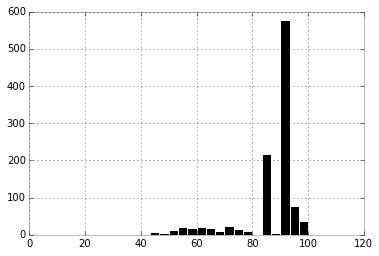

In [15]:
print 'Average ratio:', Unmatched['ratio'].mean()
print 'ratio stD:', Unmatched['ratio'].std()
Unmatched.ratio.hist(color='k', bins=30);

Yet the best option to be sure - check all candidates.

In [16]:
Unmatched[Unmatched.ratio >85].sort_values(by='ratio').head(10)

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,match,ratio
560,Reeds Basket Willow's Swamp,STATEN ISLAND,reeds basket willow's swamp,R,reed's basket willow swamp park,NaN,"(reed's basket willow swamp park, 86)",86
109,Kissena Corridor East,QUEENS,kissena corridor east,Q,kissena corridor park,NaN,"(kissena corridor park, 86)",86
229,Ehrenreich-Austin St Playground,QUEENS,ehrenreich-austin st,Q,ehrenreich-austin playground,NaN,"(ehrenreich-austin playground, 87)",87
1667,Highbridge Recreation Center,MANHATTAN,highbridge recreation center,M,recreation center 54,NaN,"(recreation center 54, 87)",87
290,Bealin Square and Seth Low Playground,BROOKLYN,bealin square and seth low,B,seth low playground/ bealin square,NaN,"(seth low playground/ bealin square, 87)",87
857,Floyd Patterson Field,BROOKLYN,floyd patterson field,B,floyd patterson ballfields,NaN,"(floyd patterson ballfields, 89)",89
1493,Dr Ronald E McNair Playground,BROOKLYN,dr ronald e mcnair,B,dr. ronald mcnair park,NaN,"(dr. ronald mcnair park, 89)",89
1032,John Adams Playground,QUEENS,john adams,Q,john adams playground,NaN,"(john adams playground, 90)",90
1000,Glendale Playground,QUEENS,glendale,Q,"""uncle"" vito e. maranzano glendale playground",NaN,"(""uncle"" vito e. maranzano glendale playground...",90
1040,Old Town Playground,STATEN ISLAND,old town,R,old town playground,NaN,"(old town playground, 90)",90


In [17]:
Matched['ratio'] = 100
JoinedD = pd.concat([Matched, Unmatched.drop('match', 1)]).sort_values(by='ratio')

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
JoinedD.head()

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,ratio
1062,Pool - PS 46 Playground,Unspecified,ps 46,?,???,NaN,0
1272,Alley Pond Park - Nature Center,Unspecified,alley pond park - nature center,?,???,NaN,0
1021,Ten Mile River Playground,Unspecified,ten mile river,?,???,NaN,0
565,Playground 62 - PS 220,QUEENS,62 - ps 220,Q,225 street malls,NaN,38
1249,Double Nickel Playground - PS 55,STATEN ISLAND,double nickel - ps 55,R,bunker ponds park,NaN,41


In [19]:
JoinedD.describe()

,ratio
count,1689.000000
mean,90.558911
std,11.628083
min,0.000000
25%,90.000000
50%,90.000000
75%,100.000000
max,100.000000


In [22]:
JoinedD.to_csv(PARQA + 'data/Ontology/matched_unmattched2_b.csv' , encoding='utf8')

## Here is manual validation part
done in Open Refine 

In [23]:
verified = pd.read_csv(PARQA + 'data/Ontology/matched_unmattched_verified.csv' , encoding='utf8')
verified.head()

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,ratio,verified
0,Alley Pond Park - Nature Center,Unspecified,alley pond park - nature center,?,???,NaN,0,False
1,Pool - PS 46 Playground,Unspecified,ps 46,?,???,NaN,0,False
2,Ten Mile River Playground,Unspecified,ten mile river,?,???,NaN,0,False
3,Playground 62 - PS 220,QUEENS,62 - ps 220,Q,225 street malls,NaN,38,False
4,Double Nickel Playground - PS 55,STATEN ISLAND,double nickel - ps 55,R,bunker ponds park,NaN,41,False


In [25]:
defined = verified[verified.verified==True]

print "ENTITIES"
print 'Defined totally: ',len(defined) 
print 100.0*len(defined)/len(verified), '%'

ENTITIES
Defined totally:  1362
80.6394316163 %


In [46]:
callParksMatched = callP.merge(defined[['Park Facility Name','SIGNNAME']], how='left', on=['Park Facility Name'])

In [47]:
callParksMatched.head(2)

,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,...,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,year,SIGNNAME
0,842,31705187,2015-10-07 20:39:09,NaN,DPR,Department of Parks and Recreation,Maintenance or Facility,Structure - Outdoors,Park,10128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,ruppert park
1,882,31704530,2015-10-07 20:23:33,NaN,DPR,Department of Parks and Recreation,Maintenance or Facility,Graffiti or Vandalism,Park,11215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,prospect park


In [48]:
print "CALLS"
print 'Defined totally: ',len(callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]) 
print 100.0*len(callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]) /len(callParksMatched), '%'

CALLS
Defined totally:  46786
89.3442309896 %


In [56]:
callParksMatched.groupby('Borough').agg({'SIGNNAME': [lambda x: sum(pd.isnull(x)), size]})

SIGNNAME       
              <lambda>   size
Borough                      
BRONX              455   7156
BROOKLYN          1896  14259
MANHATTAN         1417  17616
QUEENS            1378  10884
STATEN ISLAND      415   2432
Unspecified         19     19

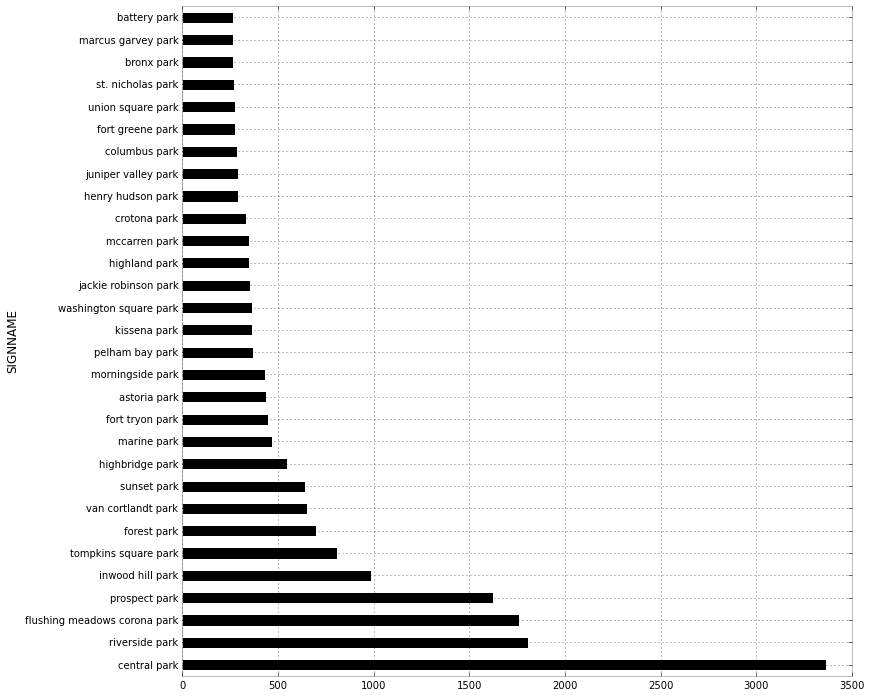

In [66]:
callParksMatched.groupby('SIGNNAME').size().sort_values(ascending=0).head(30).plot(kind='barh', color='k', figsize=(12,12));

In [ ]:
defined.to_csv(PARQA + 'data/Ontology/defined.csv' , encoding='utf8')

In [57]:
undefined = verified[verified.verified==False].reset_index()
print undefined['Park Facility Name']

0            Alley Pond Park - Nature Center
1                    Pool - PS 46 Playground
2                  Ten Mile River Playground
3                     Playground 62 - PS 220
4           Double Nickel Playground - PS 55
5                  Mount Playground - PS 174
6                              35 Playground
7                              Playground 70
8          Francis Lewis Playground - PS 130
9                          PS 149 Playground
10                Jamaica Playground - PS 40
11            Castlewood Playground - PS 186
12                  Pool - PS 186 Playground
13              Terrapin Playground - JHS 51
14           100 Percent Playground - PS 242
15                     Israel Putnam - PS 44
16           100 Percent Playground - PS 242
17                      Sandpiper Playground
18                           Beach - Orchard
19              Terrapin Playground - JHS 51
20                        Kennedy Playground
21             Sy Seplowe Playground - PS 94
22        

In [196]:
undefined.to_csv(PARQA + 'data/Ontology/undefined.csv' , encoding='utf8')